# **Installations and Imports**
**RUN ON GPU!!!**

---






In [ ]:
!pip install gymnasium
!pip install stable-baselines3[extra]
!pip install ta
!pip install yahoo_fin
!pip install lxml[html_clean]
!pip install quantstats
!pip install vaderSentiment
!pip install nest_asyncio
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b3b881be3c78cadf747d443df361ca41fdeec5a18de9e50ef2f83516bb81dccf
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━

In [ ]:
#Environment Imports
import gymnasium as gym
from gymnasium import Env

#Math/Visualization/DF imports
from google.colab import drive
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from ta import add_all_ta_features
import ftplib
import os
import io
import requests
import requests_html
from yahoo_fin.stock_info import get_data
import quantstats as qs
import asyncio
import asyncpraw
import nest_asyncio
import datetime as dt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Stable Baselines Imports Import
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

# **Background**



Before we finalized our exact question, we first did research and looked into the different ways that people have used machine learning to trade stocks. We found papers applying different machine learning techniques, such as convolutional neural networks, and reinforcement learning, to this problem.

* CNN
  * http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/ashwin_final_paper.pdf
* Reinforcement Learning for Stock Trading
  * https://arxiv.org/pdf/2111.09395 (FinRL)
  * https://openfin.engineering.columbia.edu/sites/default/files/content/publications/neurips_2018.pdf
  
After reading, for our project, our goal was to create a deep reinforcement learning model that can profitably trade the SPDR S&P 500 Trust ETF (SPY).

Deep Reinforcement Learning (DRL) is a type of artificial intelligence that teaches computers how to make decisions by learning from experiences. Imagine a game of chess. The agent is the chess-playing AI. The environment is the chessboard. The agent makes moves, the moves are the policy of the agent. If the move brings the agent closer to winning, it gets a reward. If it makes a mistake, it gets a penalty. At first, the AI knows nothing about chess strategies. It plays randomly, often losing games. Over time, it learns which moves lead to winning more often, or which moves increase reward, and starts focusing on those. The "deep" part refers to neural networks, which act like a brain for the AI. The neural network processes the board's complex layout and evaluates the possible moves. It learns patterns, like recognizing when an opponent’s king is vulnerable or when a piece is under threat.

So, we also need to choose an agent to train in our SPY environment. Which agent is the best for our purposes? Of the papers we read, we found that DDPG was best suited for our model due to our sample size and our policy needs. DDPG has a deterministic policy, which means it directly maps states of the environment to certain actions. This suits trading since, for example, if a stock price is gearing up for a big jump, we want our model to buy.

Using Deep Reinforcement Learning to create a stock trading model that would know when to hold, sell, or buy seemed like an interesting idea to base our final project on. The main paper we looked at regarding reinforcement learning used FinRL, which is an open-source framework that simplifies the application of Deep Reinforcement Learning in quantitative finance. Their model addresses data preprocessing, environment simulation, and strategy back testing. It features a three-layer architecture (environment, agent, and application layers), and includes tutorials for tasks like stock trading and cryptocurrency trading, while allowing customization for advanced users.

For data, we decided to use the SPDR S&P 500 Trust ETF (SPY) data, Federal Funds Rate data, and sentiment data from Reddit. The SPDR S&P 500 Trust ETF is an exchange-traded fund designed to track the S&P 500 index, which contains 500 companies.


# **Dataframes and Basic Environment**


---



* **SPY Data** - For the SPY data we used the get_data function from the yahoo_fin package which pulls stock data from Yahoo finance. We pulled daily SPY information with columns for the date, opening price, closing price, highest price, lowest price, and volume. We performed some basic data cleaning on this dataset, like changing data types and changing column names. Later, we use this data with the add_all_ta_features function, from the ta python library, to create other metrics to feed our model.

* **Federal Funds Rate Data** - For the Federal Funds Rate, we downloaded the data from the website of the St. Louis Federal Reserve Bank. The dataset contains two columns, one of the date and one with the Federal Funds Rate. The Federal Funds Rate is the interest rate that banks charge one another to borrow or lend money over short periods of time. This rate is set by the government and impacts the market. Generally speaking, when the Federal Funds Rate is low it tends to be better for the economy since it is cheaper to borrow money, resulting in more investments and spending. To clean this data, we standardized the dates so we could merge this data with the SPY data, we chronologically reordered the data, and since the Federal Funds Rate is updated monthly while our SPY data updates daily, we used forward fill to stretch the rates across the whole month.

* **Sentiment Data** -  Sentiment analysis computationally categorizes an opinion expressed in text and determines how people feel regarding a stock or the market. We used sentiment from Reddit's "r/WallStreetBets" regarding the biggest companies in the S&P 500.

These Dataframes were all combined together and split into two dataframes.

- A Training Dataframe with data from May 2015 - December 2021

- A Testing Dataframe with data from December 2021 - December 2024

Our split was done within this timeframe as to lineup with our reddit sentiment analysis, which only contained data going as far back as 2013.


## SPY Dataframes

In [ ]:
#Our SPYTraining Dataframe

start = "05/23/2015" #First date available in reddit sentiment analysis
end = "12/01/2021"
spy_train = get_data("spy", start_date=start, end_date=end, index_as_date = True, interval="1d")
spy_train = spy_train.drop("ticker", axis = 1)

#Making volume a float64
spy_train.volume = spy_train.volume.astype("float64")

#Changing the column names
spy_train = spy_train.reset_index()
spy_train.columns = ["Date","Open","High","Low","Close","Adjclose","Volume"]
spy_train.set_index("Date",inplace=True)
spy_train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adjclose,Volume
Date,,,,,,
2015-05-26,212.399994,212.910004,210.199997,210.699997,178.409103,124308600.0
2015-05-27,211.250000,212.979996,210.759995,212.699997,180.102631,93214000.0
2015-05-28,212.330002,212.589996,211.630005,212.460007,179.899384,74974600.0
2015-05-29,212.380005,212.429993,210.820007,211.139999,178.781708,124919600.0
2015-06-01,211.940002,212.339996,210.619995,211.570007,179.145782,93338800.0


In [ ]:
#Our SPYTesting Dataframe

start = "12/02/2021"
end = "12/02/2024"
spy_test = get_data("spy", start_date=start, end_date=end, index_as_date = True, interval="1d")
spy_test = spy_test.drop("ticker", axis = 1)

#Making volume a float64
spy_test.volume = spy_test.volume.astype("float64")

#Changing the column names
spy_test = spy_test.reset_index()
spy_test.columns = ["Date","Open","High","Low","Close","Adjclose","Volume"]
spy_test.set_index("Date",inplace=True)
spy_test.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adjclose,Volume
Date,,,,,,
2021-12-02,450.730011,459.070007,450.309998,457.399994,437.679932,127637800.0
2021-12-03,459.170013,460.299988,448.920013,453.420013,433.871613,137331600.0
2021-12-06,456.130005,460.790009,453.559998,458.790009,439.010101,98977500.0
2021-12-07,464.410004,468.880005,458.649994,468.279999,448.090942,95484700.0
2021-12-08,468.700012,470.000000,466.829987,469.519989,449.277466,72238800.0


## Federal Funds Dataframe

In [ ]:
fed = pd.read_csv("https://raw.githubusercontent.com/ddutche/RL-Trader/refs/heads/main/FEDFUNDS.csv")
#Standardizing the dates so we can merge over them

fed["Date"] = pd.to_datetime(fed["DATE"])
fed=fed.drop(columns=["DATE"],axis=1)
fed.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,FEDFUNDS,Date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01


In [ ]:
#fed data is monthly so we need to stretch these values across the entire month

fed.set_index("Date", inplace=True)
fed = fed["FEDFUNDS"].resample("D").ffill().reset_index()
fed.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,FEDFUNDS
0,1954-07-01,0.8
1,1954-07-02,0.8
2,1954-07-03,0.8
3,1954-07-04,0.8
4,1954-07-05,0.8


## Merging Spy and Federal Funds Dataframe

In [ ]:
spy_test = pd.merge(spy_test, fed, on="Date", how="inner")
spy_train = pd.merge(spy_train, fed, on="Date", how="inner")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
spy_test.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adjclose,Volume,FEDFUNDS
0,2021-12-02,450.730011,459.070007,450.309998,457.399994,437.679932,127637800.0,0.08
1,2021-12-03,459.170013,460.299988,448.920013,453.420013,433.871613,137331600.0,0.08
2,2021-12-06,456.130005,460.790009,453.559998,458.790009,439.010101,98977500.0,0.08
3,2021-12-07,464.410004,468.880005,458.649994,468.279999,448.090942,95484700.0,0.08
4,2021-12-08,468.700012,470.000000,466.829987,469.519989,449.277466,72238800.0,0.08


## Adding Sentiment Analysis

## **Sentiment Analysis**

Sentiment analysis is a technique used to understand the emotional tone or attitude expressed in text. In the context of financial markets, it involves analyzing textual data such as social media posts and news headlines to gauge the overall market sentiment. This information can help traders anticipate price movements, as a largely positive sentiment might precede rising prices, while negative sentiment could signal a decline.

In this project, sentiment analysis is integrated using data from the Reddit community "r/WallStreetBets," a popular forum where retail traders and investors discuss market conditions and specific stocks.

1. **Data Collection:**  
   Using the `asyncpraw` Python wrapper for the Reddit API, the code searches for posts mentioning the top 14 largest S&P 500 companies by their ticker symbols or names. It fetches titles and self-text from posts made within the specified date range. The top 14 biggest companies were determined from [Investopedia](https://www.investopedia.com/best-25-sp500-stocks-8550793) where all 14 companies have an index weight of at least 1%.

2. **Sentiment Calculation:**  
   After collecting the posts, it combines each post’s title and body text into a single string and then uses the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analyzer to compute a "compound" score. VADER is a rule-based tool specifically tuned to the nuances of social media text, providing an aggregated sentiment rating ranging from -1 (very negative) to +1 (very positive).

3. **Aggregation by Date:**  
   Individual post scores can be noisy, so the project averages the sentiment scores per day. This daily sentiment metric provides a smoother, more reliable indicator of the market’s mood around that day’s news and discussions.

4. **Merging with Market Data:**  
   The daily sentiment scores are then forward-filled to ensure a sentiment value is available for each trading day, even those without new posts. Finally, this processed sentiment data is merged into the main dataset alongside other features, such as SPY prices and the Federal Funds Rate. By doing this, the reinforcement learning agent can consider not only price movements and interest rates but also the "emotional" context of the market as expressed through Reddit chatter.

Incorporating sentiment provides the trading model with a richer understanding of market conditions. Prices don't move only on historical price data or macroeconomic indicators; they are also influenced by market psychology and investor behavior. A spike in positive discussion about a stock might reflect growing optimism, while negative sentiment could indicate fear and uncertainty. By integrating these sentiment scores into the state space of the DRL agent, the model may identify patterns where certain sentiment trends precede profitable trades.

This sentiment analysis step enriches our DRL agent by enabling it to use both quantitative and qualitative signals, thereby improving its decision-making process and trading performance compared to a model relying solely on historical price and economic data.

In [ ]:
nest_asyncio.apply()
reddit = asyncpraw.Reddit(client_id='',
                          client_secret='',
                          user_agent='')
analyzer = SentimentIntensityAnalyzer()
tickers_and_names = {
    'AAPL': 'Apple',
    'NVDA': 'NVIDIA',
    'MSFT': 'Microsoft',
    'AMZN': 'Amazon',
    'META': 'Meta',
    'GOOGL': 'Google',
    'TSLA': 'Tesla',
    'BRK.B': 'Berkshire Hathaway',
    'AVGO': 'Broadcom',
    'JPM': 'JPMorgan Chase',
    'LLY': 'Eli Lilly',
    'UNH': 'UnitedHealth',
    'V': 'Visa',
    'XOM': 'Exxon Mobil',
}

start_date = dt.datetime(2015, 1, 1)
end_date = dt.datetime(2024, 12, 2)

async def collect_reddit_posts(tickers_and_names, start_date, end_date):
    reddit_posts = []

    for ticker, name in tickers_and_names.items():
        search_query = f"{ticker} OR {name}"
        posts = []
        subreddit = await reddit.subreddit('wallstreetbets')
        async for submission in subreddit.search(search_query, time_filter='all', limit=1000):
            submission_date = dt.datetime.fromtimestamp(submission.created_utc).date()
            if start_date.date() <= submission_date <= end_date.date():
                post = {'date': submission_date, 'title': submission.title,
                        'selftext': submission.selftext, 'ticker': ticker, 'name': name}
                posts.append(post)
        df = pd.DataFrame(posts)
        reddit_posts.append(df)

    if reddit_posts:
        reddit_df = pd.concat(reddit_posts, ignore_index=True)
    else:
        reddit_df = pd.DataFrame()
    return reddit_df

reddit_df = asyncio.run(collect_reddit_posts(tickers_and_names, start_date, end_date))
if not reddit_df.empty:
    reddit_df['text'] = reddit_df['title'].fillna('') + ' ' + reddit_df['selftext'].fillna('')
    reddit_df['sentiment'] = reddit_df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    reddit_sentiment = reddit_df.groupby(['date'])['sentiment'].mean().reset_index()
    reddit_sentiment.rename(columns={'date': 'Date', 'sentiment': 'average_sentiment'}, inplace=True)
else:
    reddit_sentiment = pd.DataFrame(columns=['Date', 'average_sentiment'])
print(reddit_sentiment)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


            Date  average_sentiment
0     2015-05-23           0.410800
1     2015-10-13          -0.904600
2     2015-10-20           0.000000
3     2015-10-22          -0.949500
4     2015-12-15           0.190100
...          ...                ...
1470  2024-11-26           0.266750
1471  2024-11-27           0.097575
1472  2024-11-28           0.243650
1473  2024-11-30           0.999300
1474  2024-12-02          -0.739500

[1475 rows x 2 columns]


In [ ]:
#Similar to fedfunds, we have to ffill these values so they can be inputted into our dataframe

red = reddit_sentiment.reset_index()
red["Date"] = pd.to_datetime(red["Date"])
red = red.set_index("Date")
red = red["average_sentiment"].resample("D").ffill().reset_index()
red.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,average_sentiment
0,2015-05-23,0.4108
1,2015-05-24,0.4108
2,2015-05-25,0.4108
3,2015-05-26,0.4108
4,2015-05-27,0.4108


## Merging Spy and Sentiment Analysis

In [ ]:
spy_test = pd.merge(spy_test, red, on="Date", how="inner")
spy_train = pd.merge(spy_train, red, on="Date", how="inner")
spy_train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Open,High,Low,Close,Adjclose,Volume,FEDFUNDS,average_sentiment
0,2015-05-26,212.399994,212.910004,210.199997,210.699997,178.409103,124308600.0,0.12,0.4108
1,2015-05-27,211.250000,212.979996,210.759995,212.699997,180.102631,93214000.0,0.12,0.4108
2,2015-05-28,212.330002,212.589996,211.630005,212.460007,179.899384,74974600.0,0.12,0.4108
3,2015-05-29,212.380005,212.429993,210.820007,211.139999,178.781708,124919600.0,0.12,0.4108
4,2015-06-01,211.940002,212.339996,210.619995,211.570007,179.145782,93338800.0,0.13,0.4108


# **Model Creation**

##**Trading Environment**

There are many parts to this environment, in which our agent can take 3 actions: buying, selling, and holding. The explanation of how our environment works will be broken down by function below:

**Init Function**

* start - the money your agent started with

* balance - the money your agent has

* window_size -  depicts how many days in the past you want your agent to remember

* action_space - defines the range of numbers our actions will be represented by

* observation_space - defines what we want our agent to see during each observation

* ticker - lets us iterate over the df

* amount - the starting amount of stock held

* net_worth - the value for the amount of money AND stocks you have

* previous_net_worth - the net worth you had in the previous step

* net_worth_history - a list of your net worth across each step

**Observation Function**

* Within this environment our agent observes the Close value, federal funds rate, and average sentiments of our dataset, while remembering the last 10 days and their values. Each of these 10 day windows are put into frames in the

**Step Function**

* Here, we first set a price for our agent to look at, that price being the Close value. Then our agent either buys, sells, or holds depending on what its action value is.

  Buying - An action value which is between 0.1 and 1 would cause the agent to BUY stock, and the magnitude of which it buys depends on how close to 1 this value is

  * EX: A buy value of 0.15 would cause the agent to buy a little stock, while a buy value of 1 would make the agent spend its entire balance on stock

  Selling - An action value between -0.1 and -1 would cause the agent to SELL stock, selling more the closer it is to 1

  * EX: Similar to the last example, a sell value of 0.15 would cause the agent to sell a little stock, while a sell value of 1 would make the agent sell its entire balance on stock

  Holding - An action value that is between -0.1 and 0.1 would cause our agent to just hold onto the stock, choosing not to buy or sell any of it on this step.

* After choosing its action, we move to the next row in the dataframe by increasing the value of ticker, and calculating the agents reward as a measure of its net worth

  * Our Agent looks for an increase in networth after each step, encouraging it to make smarter trades in order to recieve reward

**Update Function**

* Calculates the Agents net worth networth every step

**Reset Function**

* Resets the environment back to its starting values, and also introduces some randomness to the dataframe in order to help with not overfitting the model if trained too long

**Plot Function**

* Returns the Number of Steps, Change in Net Worth, and Net Worth of your agent. Also makes a graph to display its Net Worth over time.






In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete


import gymnasium as gym

#heavily based off the Gym_anytrading environment, simple agent that learns to sell and buy and hold, and tries
#to make a profit based on the balance you give it
class Profit(gym.Env):
    def __init__(self, df, start, window_size):
        self.start = start #saving the money we start with value
        self.balance = start #this will change (the balance we have)
        self.window_size = window_size
        self.df = df
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32) #for buying selling and holding
        self.observation_space = Box(low=0, high=np.inf, shape=(self.window_size, df[["Close","FEDFUNDS","average_sentiment"]].shape[1]), dtype=np.float32) #defining the observationspace
        self.ticker = window_size #so we know position in training
        self.amount = 0 #Amount of stock held
        self.net_worth = self.balance #total value of our money and assets
        self.previous_net_worth = self.net_worth #setting a variable for comparison later
        self.net_worth_history = [] #For plotting

    def observation(self):
        frame = self.df.iloc[self.ticker - self.window_size:self.ticker]
        return frame[["Close","FEDFUNDS","average_sentiment"]].values #selecting Close, fedfunds, and sentiment as our indicators

    def step(self, action):
        done = False #checking if done
        price = self.df.iloc[self.ticker]["Close"] #setting a price of the stock
        action = np.clip(action[0], -1, 1) #Keeping our action between 1 and -1

        #buying (action 1)
        if action > 0.1:
            bought= (self.balance / price) * action #Buying a certain amount of stock, dependent on strength of action
            self.amount += bought
            self.balance -= bought * price

        #selling (action -1)
        elif action < -0.1 and self.amount > 0: #only sell if were holding stock
            sold = self.amount * abs(action)
            self.balance += sold * price
            self.amount -= sold
        else: #holding
            pass


        self.ticker += 1 #moving to next step in df
        self.update(price) #calling update def

        done = self.ticker >= len(self.df) - 1 #checking if done
        reward = self.net_worth - self.previous_net_worth #calculating reward
        self.previous_net_worth = self.net_worth #for self referencing
        self.net_worth_history.append(self.net_worth)
        return self.observation(), reward, done, False, {}

    def update(self, price):
        self.net_worth = self.balance + (self.amount * price)

    def reset(self, seed=None, options=None): #resetting params
        super().reset(seed=seed)
        self.ticker = self.window_size
        self.balance = self.start
        self.amount = 0
        self.net_worth = self.start
        self.prev_net_worth = self.start
        self.df["Close"] += np.random.normal(0, 0.01, size=len(self.df)) #So we can have different prices on different resets
        self.net_worth_history = []
        return self.observation(), {"seed": seed}

    def plot(self):
      #creates the graph
        plt.figure(figsize=(10, 6))
        plt.plot(self.net_worth_history)
        plt.title("Net Worth Over Time")
        plt.xlabel("Step")
        plt.ylabel("Net Worth")
        plt.grid(True)
        plt.show()
        #shows text values
        print(f"Steps = {self.ticker}")
        print(f"Total profit = ${self.net_worth-self.start}")
        print(f"Net worth = ${self.net_worth}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Trading Agents**





### DDPG Trading Agent

Heres the code for making a DDPG Agent, our premade agent will be loadable later on in this section.

  If you'd like to make your own DDPG agent:

* 1) DO NOT run the ["Loading the DDPG Model"](#scrollTo=UY3oNY8P8IZT) codeblock

  2) Skip to ["Making the DDPG Agent"](#scrollTo=Oayyahr06_m2), and proceed from there


  On the other hand, if you'd like to just load our premade DDPG Agent:

  * 1) Run the ["Loading the DDPG Model"](#scrollTo=UY3oNY8P8IZT) codeblock (Directly below this textblock)

  2) Skip to ["Evaluating The DDPG Model"](#scrollTo=Q_0pamy-5Sxt), and proceed from there

#### Loading the DDPG Model

* This is the code for loading our (writers of this notebook) model. Only run this if you'd like to perform evaluation using the agent we made, and after running this, skip to ["Evaluating The Model"](#scrollTo=Q_0pamy-5Sxt)

Your directory may be different than the one below, but basically you need...

"whatever_path_leads_up_to_here/DIDA_340_Final_Project/Models/DDPG_Model"

This lets the ipynb access the "Models" folder of the ipynb, which is where we save and load models from.


Mounted at /content/drive
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


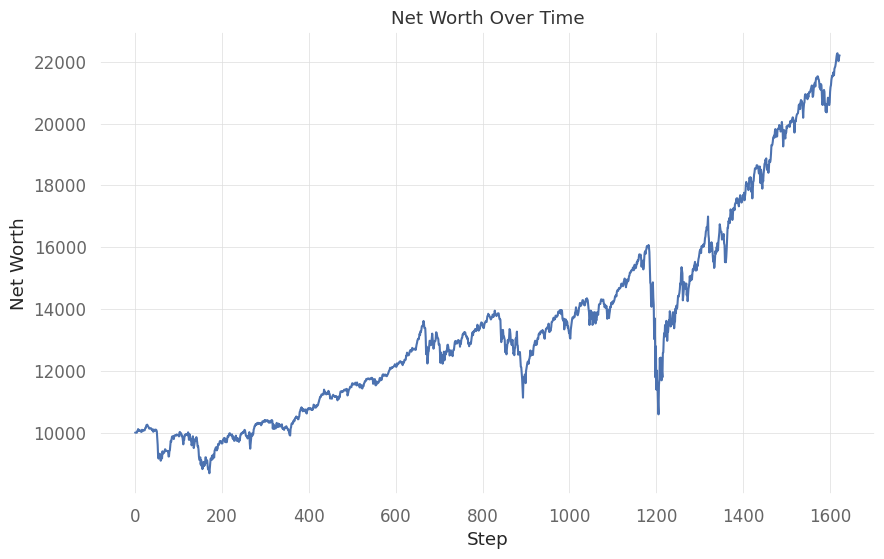

Steps = 1633
Total profit = $12205.25290076742
Net worth = $22205.25290076742


In [ ]:
drive.mount("/content/drive")
model = DDPG.load("/content/drive/MyDrive/DIDA_340_Final_Project/Models/DDPG_Model") #you might have to change this

window = 10
env = Profit(spy_train, start=10000, window_size = 10) #Starting with $10000 to match the "Practical Deep Reinforcement Learning Approach for Stock Trading" model

seed = np.random.randint(0, 10000) #changes the starting weights of the model in between runs
env.reset(seed=seed)
model.set_env(env)
model.learn(total_timesteps=(len(spy_train) - 2*(window))) #setting the limits, so it can only train within a single iteration of the dataframe

env.plot() #Plotting the DDPG Model's networth overtime

#### Making the DDPG Agent

* Its important to note, sometimes when creating an agent it doesn't perform optimally. In this case, the agent might fail to understand the reward system, or run out of money for example. In this case your graph will likely look like a flat line after a certain point.

  * This is a normal thing to happen since the agent is experiencing this environment for the first time without ANY KNOWLEDGE of how to accumulate reward. The only way to ensure an agent won't fail is if it know the environment beforehand and how to accumulate reward, which would make it a flawed agent in itself and likely cause it to overfit.

* A successful agent will eventually learn how to accumulate reward and can be stored for later, which is why we have a save function later on in order to hold onto these agents while deleting the failed ones.

If the agent you create ends up displaying a graph with a flat line at the end, then the code block will have to be reran. It may take a few tries, or none at all and you get it the first time.

These are the exact parameters our agent was trained on, meaning it started with the same weights as ours, so eventually you should get a graph that looks near identical to ours.


In [ ]:
#Here, we'll be using our Training Dataset

window = 10
env = Profit(spy_train, start=10000, window_size = 10) #Starting with $10000 to match the "Practical Deep Reinforcement Learning Approach for Stock Trading" model

seed = np.random.randint(0, 10000) #changes the starting weights of the model in between runs

n_actions = env.action_space.shape[-1]
model = DDPG('MlpPolicy', env, verbose=1,seed= seed, action_noise=NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))) #added noise for slight variations in data
env.reset(seed=seed)
model.learn(total_timesteps=(len(spy_train) - 2*(window))) #setting the limits

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


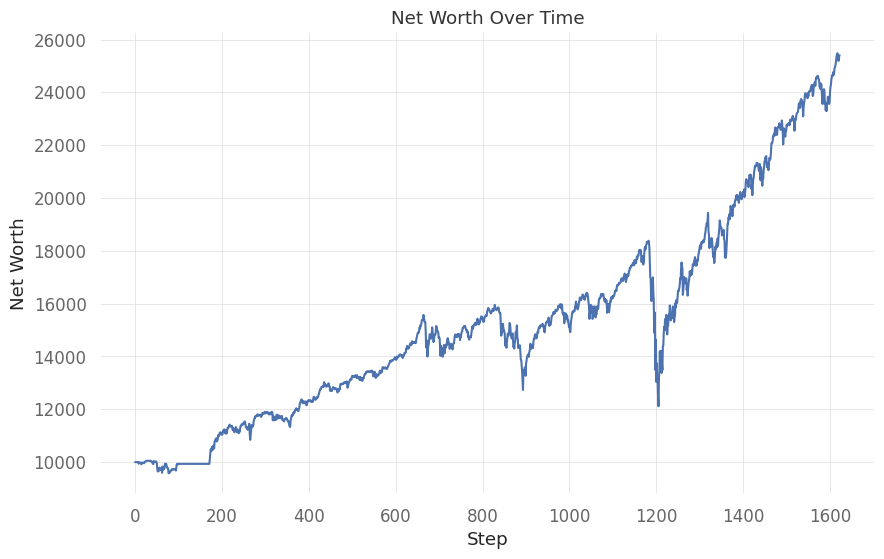

Steps = 1633
Total profit = $15399.816042685841
Net worth = $25399.81604268584


In [ ]:
env.plot() #Plotting the DDPG Model's networth overtime

#### Saving the DDPG model

Like before, you may have to change the routing

In [ ]:
drive.mount("/content/drive") #This is just the code required to save the model, ours will be called something different but if you want to make a model at somepoint, itll be saved as "DDPG_Model_Test"

model.save("/content/drive/MyDrive/DIDA_340_Final_Project/Models/DDPG_Model_Test") # (your directory might be a little different)
model = DDPG.load("/content/drive/MyDrive/DIDA_340_Final_Project/Models/DDPG_Model_Test") # And this is how you'd load in your model (assuming you have the same directory)

#How we saved and loaded our model vvvvvv

#model.save("/content/drive/MyDrive/DIDA_340_Final_Project/Models/DDPG_Model")
#model = DDPG.load("/content/drive/MyDrive/DIDA_340_Final_Project/Models/DDPG_Model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Evaluating The DDPG Model

**Evaluating with Training DATA**

* Similar to Null accuracy in machine learning, a way to perform evaluations on an agent is to see what your results would look like if an agent chose a random action each and everytime it had the chance

* Using this random simulation as a metric, a working model should perform better (i.e. have a higher net worth in the end)

In [ ]:
#From Gym Anytrading for evaluation https://github.com/AminHP/gym-anytrading

#This is what would happen if our agent randomly chose what to do

observation = env.reset(seed=8675309)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


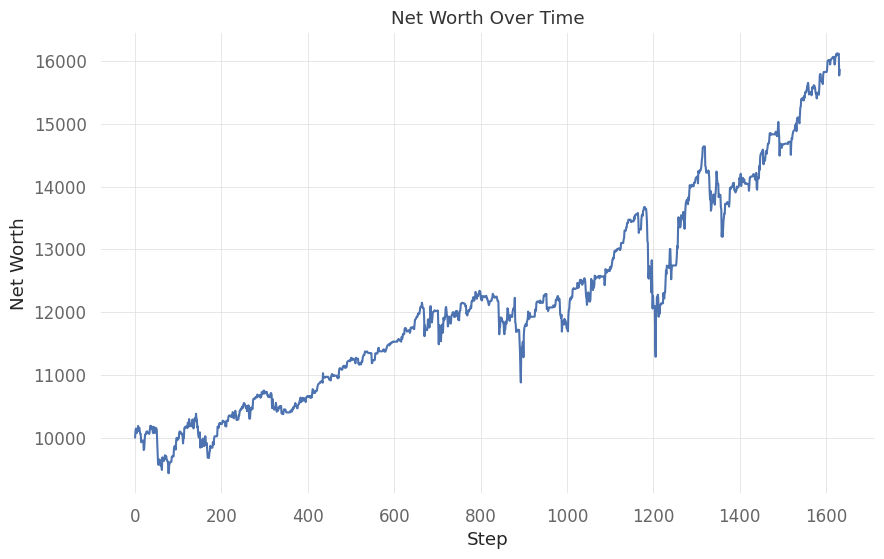

Steps = 1642
Total profit = $5863.394447257875
Net worth = $15863.394447257875


In [ ]:
env.plot() #Plotting the RANDOM Net Worth overtime

**Evaluating with Testing Data**

* Its important to note that the test dataframe is much smaller than the training, which means we have less time to accumulate reward, so its expected to have a smaller net worth gain in the testing dataset compared to the training

* This code is a little different than the training since we don't actually want the model to train based off this code, we just want it to make predictions.

In [ ]:
test_env = Profit(df=spy_test, start=10000, window_size=10) #Creating a test env using the test dataframe

obs, info = test_env.reset(seed)
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = test_env.step(action)

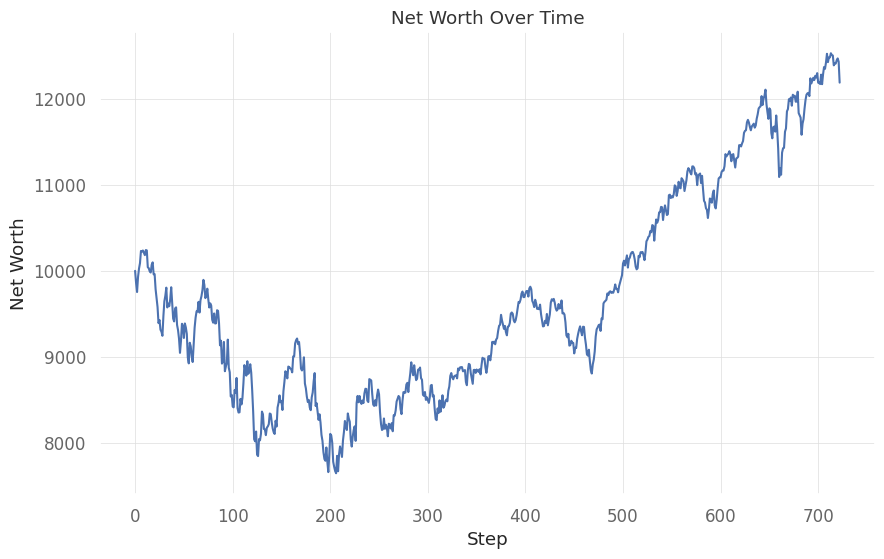

Steps = 733
Total profit = $2190.9013014083903
Net worth = $12190.90130140839


In [ ]:
test_env.plot() #plotting the networth using the testing environment

In [ ]:
#Now we'll be doing a similar thing to before, seeing what would happen if we made random choices instead

observation = test_env.reset(seed=8675309)
while True:
    action = test_env.action_space.sample()
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    if done:
        break

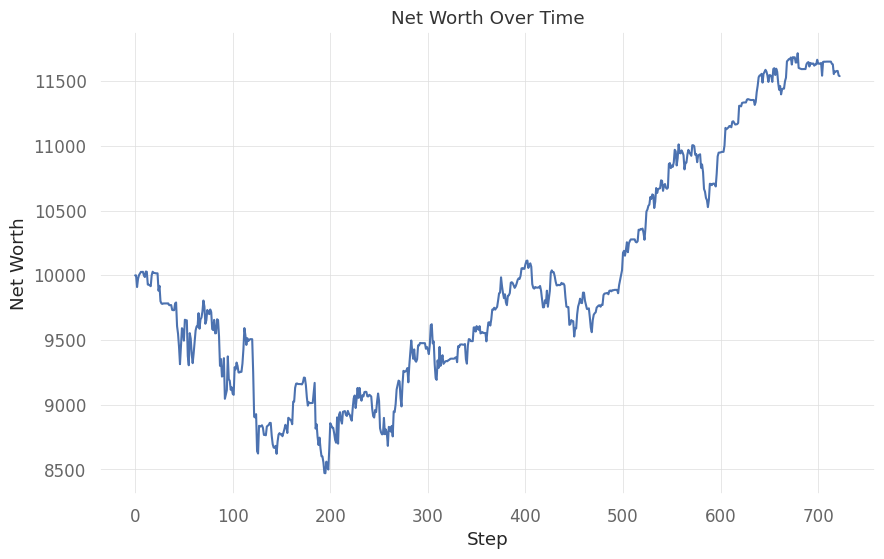

Steps = 733
Total profit = $1540.6018187077425
Net worth = $11540.601818707742


In [ ]:
test_env.plot() #what would happen if you RANDOMLY chose what to do in the testing set

# **Analysis**

After training, our DDPG model tended to end with a net worth of around \$22,000. This is a net gain of \$12,000. When our model was compared to one that would just randomly choose whether to buy, sell, or hold, our model would nearly always make more in the end. When using our testing data, our DDPG model made around \$12,191. This is a \$2,000 increase across the shorter testing time frame and would still beat the random choice model most of the time. While still uncommon, during the testing phase our model would occasionally perform worse than the random simulation, but this is likely due in part to the smaller time frame. A larger testing dataframe would likely show our agent more consistently outperform the random simulation.

The paper that was done by Columbia University tested from January 2016 to September 2018. Their model started with \$10,000 and ended with \$19,761, which is a total profit of \$9,761. In comparison, while our model made more money, it took a lot longer to do so. Similarly when it came to the Testing data, our model performed slightly worse than theirs in a similar timeframe.

Another thing to note is how rigid our model is in its choices, only varying slightly in its actions each time its evaluated. This may be a result of overfitting due to the small sample size we had for our model to learn from.

So while our model did end up performing well, there is clearly still room for improvement when it comes to volume of training data in particular.






# **Conclusion**

In this paper, we created a deep reinforcement learning model that could profitably trade the SPDR S&P 500 Trust ETF (SPY). We used three other papers that applied different machine learning techniques to help us. One looked at convolutional neural networks and the other two looked at reinforcement learning. For data, we used the SPDR S&P 500 Trust ETF (SPY) data, Federal Funds Rate data, and sentiment data from Reddit. These data frames were combined and split into two. The first being a training data frame, which lasted from 2015-2021, and the second being a testing data frame, which lasted from 2021 to 2024. Our agent was able to make three actions: buying, selling, or holding. We chose the DDPG agent because of its deterministic policies. Sentiment analysis was integrated using data from the Reddit community "r/WallStreetBets." This enriched our DRL agent by enabling it to use both quantitative and qualitative signals. Our models that used the training data frame and testing data frame were able to beat a random choice model consistently. However, the model created by Columbia University students and professors was more efficient than our model. In terms of future directions, we could look at improving our model by incorporating a larger dataset. We could also look at making our environment more customizable, aswell as developing other agents like an A2C agent.